In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import econml
import importlib
import pyreadr

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black
sns.set(font_scale=1.25, style="whitegrid")

In [2]:
baseline_harmonized = pyreadr.read_r(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/merged/baseline_harmonized_07272023.rds"
)[None].set_index("who")

relapse_harmonized_wide = pyreadr.read_r(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/merged/relapse_harmonized_wide_09062023.rds"
)[None].set_index("who")

stacked_list = []
for i in range(1, 6):
    stacked_list.append(
        pd.read_csv(
            "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/stacked_list_%d.csv"
            % (i),
            index_col=0,
        )
    )
df = stacked_list[0]

df_tedsa = df.loc[df["trialdata"] == 0]

In [3]:
outcome_cols = ["wk%d.relapse_this_week" % (i) for i in range(1, 11)]
outcome94 = relapse_harmonized_wide.loc[
    (relapse_harmonized_wide["project"] == "27")
    # + (relapse_harmonized_wide["project"] == "30")
    # + (relapse_harmonized_wide["project"] == "51")
][outcome_cols]

In [4]:
ct94 = baseline_harmonized.loc[
    (baseline_harmonized["project"] == "27")
    # + (baseline_harmonized["project"] == "30")
    # + (baseline_harmonized["project"] == "51")
]

In [5]:
common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

In [6]:
df_tedsa_cc = df_tedsa[common_cols]
df_tedsa_cc["S"] = 0
ct94_cc = ct94[common_cols].fillna(0)
ct94_cc["med_met"] = (
    (ct94["medicine"] == "met").astype(int).fillna(0)
)  # methadone = 1 and bupenorphine = 0
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0

# Create age categories
ct94_cc["age1"] = 0
ct94_cc.loc[ct94_cc["age"] < 15, "age1"] = 1
ct94_cc.loc[(ct94_cc["age"] > 14) & (ct94_cc["age"] < 18), "age1"] = 2
ct94_cc.loc[(ct94_cc["age"] > 17) & (ct94_cc["age"] < 21), "age1"] = 3
ct94_cc.loc[(ct94_cc["age"] > 20) & (ct94_cc["age"] < 25), "age1"] = 4
ct94_cc.loc[(ct94_cc["age"] > 24) & (ct94_cc["age"] < 30), "age1"] = 5
ct94_cc.loc[(ct94_cc["age"] > 29) & (ct94_cc["age"] < 35), "age1"] = 6
ct94_cc.loc[(ct94_cc["age"] > 34) & (ct94_cc["age"] < 40), "age1"] = 7
ct94_cc.loc[(ct94_cc["age"] > 39) & (ct94_cc["age"] < 45), "age1"] = 8
ct94_cc.loc[(ct94_cc["age"] > 44) & (ct94_cc["age"] < 50), "age1"] = 9
ct94_cc.loc[(ct94_cc["age"] > 49) & (ct94_cc["age"] < 55), "age1"] = 10
ct94_cc.loc[(ct94_cc["age"] > 54) & (ct94_cc["age"] < 65), "age1"] = 11
ct94_cc.loc[ct94_cc["age"] > 64, "age1"] = 12

# Assign the 'age1' values to 'age' column
ct94_cc["age"] = ct94_cc["age1"]

# Optionally, you can drop the 'age1' column if you no longer need it
ct94_cc.drop(columns=["age1"], inplace=True)
ct94_cc["S"] = 1
ct94_cc = ct94_cc.astype(int)

In [7]:
ct94_cc = ct94_cc.join(outcome94, how="inner")

In [36]:
ct94_cc.groupby(by="med_met").mean()[outcome_cols].diff()

,wk1.relapse_this_week,wk2.relapse_this_week,wk3.relapse_this_week,wk4.relapse_this_week,wk5.relapse_this_week,wk6.relapse_this_week,wk7.relapse_this_week,wk8.relapse_this_week,wk9.relapse_this_week,wk10.relapse_this_week
med_met,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.020954,-0.12616,-0.158609,-0.076485,-0.07188,-0.066685,-0.084872,-0.094153


In [8]:
df_primary = pd.concat([df_tedsa_cc, ct94_cc])

In [10]:
df_ = df_primary.drop(
    columns=["wk%d.relapse_this_week" % (i) for i in range(1, 10)]
).fillna(0)

In [11]:
outcome = "wk10.relapse_this_week"
treatment = "med_met"
sample = "S"
data = df_
S = df_[sample]  # indicator for the sample
Y = df_[outcome]  # outcome variable
T = df_[treatment]  # indicator for the treatment
X = df_.drop(columns=[outcome, treatment, sample])  # pre-treatment covariates

In [12]:
importlib.reload(learn)
df_v, pi, pi_m, mu_1_m, mu_0_m, e_m, data2 = learn.estimate_dml(
    data, outcome, treatment, sample, crossfit=10
)

df_v.join(S).groupby(by="S").mean()

,te,te_sq
S,,
0,-0.061811,0.036710
1,-0.004323,0.623111


In [14]:
importlib.reload(learn)
# D, w_tree, testing_data = learn.tree_opt(data, outcome, treatment, sample, leaf_proba=1)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=df_,
    outcome="wk10.relapse_this_week",
    treatment="med_met",
    sample="S",
    leaf_proba=1,
    num_trees=1000,
    vote_threshold=1 / 2,
    top_k_trees=True,
    k=100,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))
optimized_loss_forest = np.sqrt(
    np.sum(D_rash["vsq"] * D_rash["w_opt"]) / ((np.sum(D_rash["w_opt"])) ** 2)
)
print("Baseline Objective:%.4f" % (baseline_loss))
print("Optimized Objective (Forest):%.4f" % (optimized_loss_forest))

ATE Est: -0.0318
leaf                   0.500000
age                    0.002838
xrace                  0.064233
bbenzo30_base          0.061733
sex                    0.063755
bamphetamine30_base    0.205033
bcannabis30_base       0.019320
ivdrug                 0.083087
dtype: float64
Baseline Objective:0.0003
Optimized Objective (Forest):0.0003


[Text(0.4, 0.8333333333333334, 'bamphetamine30_base <= 0.5\nsamples = 100.0%\nvalue = [0.016, 0.984]'),
 Text(0.2, 0.5, 'samples = 93.3%\nvalue = [0.0, 1.0]'),
 Text(0.6, 0.5, 'ivdrug <= 0.5\nsamples = 6.7%\nvalue = [0.247, 0.753]'),
 Text(0.4, 0.16666666666666666, 'samples = 1.6%\nvalue = [1.0, 0.0]'),
 Text(0.8, 0.16666666666666666, 'samples = 5.0%\nvalue = [0.0, 1.0]')]

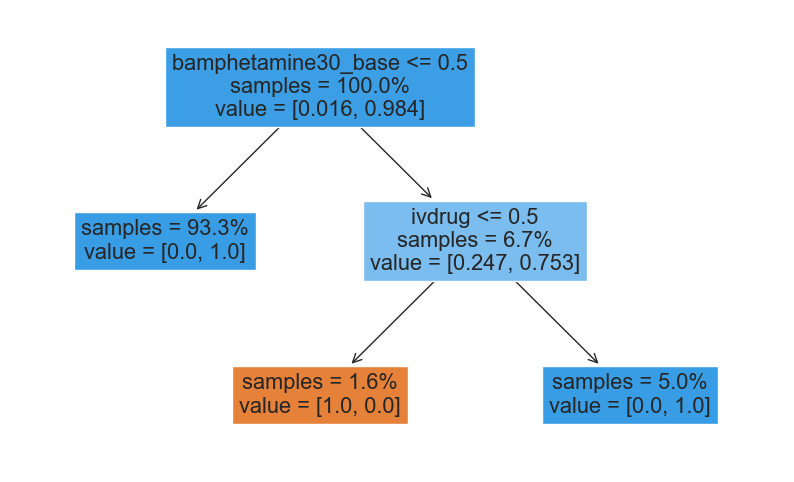

In [18]:
sns.set(font_scale=1)
fig, ax = plt.subplots(ncols=1, figsize=(10, 6), sharex=True, sharey=True)
tree.plot_tree(
    f,
    ax=ax,
    feature_names=df_.drop(columns=[outcome, sample, treatment]).columns,
    filled=True,
    proportion=True,
    impurity=False,
)

In [34]:
D_rash.to_csv("tedsa_analysis_forest_rashomon_opt.csv")

In [37]:
print(
    r"Pre Pruning, ATTE: %.5f ± %.5f"
    % (
        D_rash["v"].mean(),
        1.96 * np.sqrt(D_rash["vsq"].mean() / D_rash["w_opt"].count()),
    )
)

print(
    r"Post Pruning, ATTE: %.5f ± %.5f"
    % (
        D_rash["v"].loc[D_rash["w_opt"] == 1].mean(),
        1.96
        * np.sqrt(
            D_rash["vsq"].loc[D_rash["w_opt"] == 1].mean() / D_rash["w_opt"].sum()
        ),
    )
)

Pre Pruning, ATTE: -0.03179 ± 0.00052
Post Pruning, ATTE: -0.03718 ± 0.00051


Thoughts:
* TEDSA (observational data) has fewer covariates than experimental sample. Maybe there is different and interesting question here?